## Notebook to Fit Triple Models with RV data of multiple components

In [33]:
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm import tqdm
import matplotlib.cm as cm
from read_data import read_data,read_data2,read_rv,read_wds,read_orb6
from astrometry_model import astrometry_model,astrometry_model_vlti,triple_model,triple_model_combined,triple_model_full_vlti_combined,triple_model_full_vlti,triple_model_vlti_combined,triple_model_full_combined,triple_model_combined2,triple_model_combined3,quad_model,quad_model_combined,triple_model_vlti,triple_model_full_combined_hd1976,triple_model_full
from orbit_plotting import orbit_model,triple_orbit_model,quad_orbit_model
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import random
from PyAstronomy.pyasl import foldAt
from PyAstronomy import pyasl
from uncertainties import ufloat,umath
from uncertainties.umath import *
import emcee
import corner
ks=pyasl.MarkleyKESolver()

%matplotlib inline

In [34]:
def cart2pol(x,y):
    x=-x
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y,x) * 180 / np.pi
    if theta>0 and theta<90:
        theta_new = theta+270
    if theta>90 and theta<360:
        theta_new = theta-90
    if theta<0:
        theta_new = 270+theta
    if np.isnan(theta):
        theta_new=theta
    return(r,theta_new)

In [35]:
###########################################
## SETUP PATHS
###########################################

if os.getcwd()[7:14] == 'tgardne':
    ## setup paths for user
    path = '/Users/tgardne/ARMADA_orbits'
    path_etalon = '/Users/tgardne/etalon_epochs/etalon_fits/etalon_factors_fit.txt'
    path_wds = '/Users/tgardne/wds_targets'
    path_orb6 = '/Users/tgardne/catalogs/orb6orbits.sql.txt'
    
elif os.getcwd()[7:19] == 'adam.scovera':
    ## Adam's path
    path = '/Users/adam.scovera/Documents/UofM/BEPResearch_Data/ARMADA_orbits'
    path_etalon = '/Users/adam.scovera/Documents/UofM/BEPResearch_Data/etalon_factors_fit.txt'
    path_wds = '/Users/adam.scovera/Documents/UofM/BEPResearch_Data/wds_targets'
    path_orb6 = '/Users/adam.scovera/Documents/UofM/BEPResearch_Data/orb6orbits.sql.txt'

## Read in Data:

In [36]:
###########################################
## Specify Target
###########################################
target_hd = '220278'
note = ''
scale = 1.0 #1.00535

#emethod = input('bootstrap errors? (y/n) ')
emethod = 'n'

triple_outer='n'

query = Simbad.query_objectids('HD %s'%target_hd)
for item in query:
    if 'HIP' in item[0]:
        target = item[0].split()[1]
        print('HIP %s'%target)
    if 'WDS' in item[0]:
        target_wds = item[0][5:15]
        print('WDS %s'%target_wds)

try:
    print(target_wds)
except:
    print('No WDS number queried')
    target_wds = input('Enter WDS: ')

HIP 115404
WDS 23227-1502
23227-1502


In [37]:
###########################################
## Read in ARMADA data
###########################################
if emethod == 'y':
    print('reading bootstrap errors')
    file=open('%s/HD_%s_bootstrap.txt'%(path,target_hd))
else:
    print('reading chi2 errors')
    file=open('%s/HD_%s_chi2err.txt'%(path,target_hd))
weight=1

t,p,theta,error_maj,error_min,error_pa,error_deg,p2,theta2,error_maj2,error_min2,error_pa2,error_deg2 = read_data2(file,weight)
#t,p,theta,error_maj,error_min,error_pa,error_deg = read_data(file,weight)
p /= scale
file.close()

## Read in RV data
file_rv=open('%s/HD_%s_rv.txt'%(path,target_hd))
#weight_rv = float(input('Err for RV [1 km/s]: '))
t_rv_aa,rv_aa,err_rv_aa = read_rv(file_rv,4)
file_rv.close()

file_rv=open('%s/HD_%s_rv_ab.txt'%(path,target_hd))
#weight_rv = float(input('Err for RV [1 km/s]: '))
t_rv_ab,rv_ab,err_rv_ab = read_rv(file_rv,1)
file_rv.close()

file_rv=open('%s/HD_%s_rv_b.txt'%(path,target_hd))
##weight_rv = float(input('Err for RV [1 km/s]: '))
t_rv_b,rv_b,err_rv_b = read_rv(file_rv,1)
file_rv.close()

## multiple datasets
## Read in RV data
#file_rv=open('%s/HD_%s_rv2.txt'%(path,target_hd))
#weight_rv = float(input('Err for RV [1 km/s]: '))
#t_rv_aa2,rv_aa2,err_rv_aa2 = read_rv(file_rv,10)
#file_rv.close()

## Read in RV data
#file_rv=open('%s/HD_%s_rv3.txt'%(path,target_hd))
#weight_rv = float(input('Err for RV [1 km/s]: '))
#t_rv_aa3,rv_aa3,err_rv_aa3 = read_rv(file_rv,10)
#file_rv.close()

## Read in RV data
#file_rv=open('%s/HD_%s_rv4.txt'%(path,target_hd))
#weight_rv = float(input('Err for RV [1 km/s]: '))
#t_rv_aa4,rv_aa4,err_rv_aa4 = read_rv(file_rv,10)
#file_rv.close()

reading chi2 errors


MJD? (y,[n]):  n


FileNotFoundError: [Errno 2] No such file or directory: '/Users/tgardne/ARMADA_orbits/HD_220278_rv_ab.txt'

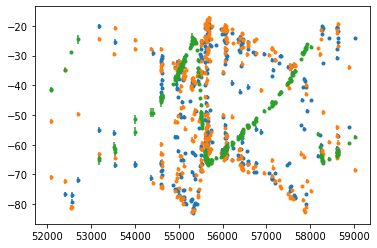

In [11]:
plt.errorbar(t_rv_aa,rv_aa,yerr=err_rv_aa,fmt='.')
plt.errorbar(t_rv_ab,rv_ab,yerr=err_rv_ab,fmt='.')
plt.errorbar(t_rv_b,rv_b,yerr=err_rv_b,fmt='.')

#plt.errorbar(t_rv_aa2,rv_aa2,yerr=err_rv_aa2,fmt='.')
#plt.errorbar(t_rv_aa3,rv_aa3,yerr=err_rv_aa3,fmt='.')
#plt.errorbar(t_rv_aa4,rv_aa4,yerr=err_rv_aa4,fmt='.')

plt.show()

In [24]:
### correct PAs based on precession (only for WDS):
coord = SkyCoord.from_name("HD %s"%target_hd,parse=True)
ra = coord.ra.value*np.pi/180
dec = coord.dec.value*np.pi/180
#theta -= (0.00557*np.sin(ra)/np.cos(dec)*((t-51544.5)/365.25))/180*np.pi

In [38]:
###########################################
## Apply etalon correction
###########################################
file=open(path_etalon)
mjd_etalon=[]
f_etalon=[]
for line in file.readlines():
    if line.startswith('#'):
        continue
    mjd_etalon.append(float(line.split()[0]))
    f_etalon.append(float(line.split()[1]))
file.close()
mjd_etalon=np.array(mjd_etalon)
f_etalon=np.array(f_etalon)

etalon_factor=[]
for i in t:
    idx = np.where(abs(i-mjd_etalon)==min(abs(i-mjd_etalon)))
    if min(abs(i-mjd_etalon))>0.5:
        print('Closest factor for %s is %s days away'%(i,min(abs(i-mjd_etalon))))
    f = f_etalon[idx][0]
    etalon_factor.append(f)
etalon_factor=np.array(etalon_factor)

print('   date      etalon factor')
for i,j in zip(t,etalon_factor):
    print(i,j)

## apply etalon correction
etalon = input('Apply etalon correction? (y/n) ')

## FIXME: make it easier to choose vlti data
vlti = input('Add indices for vlti (y/n)? ')
#vlti = 'y'
if vlti=='y':
    vlti_idx = input('enter indices (e.g. 1 2 3): ').split(' ')
    vlti_idx = np.array([int(i) for i in vlti_idx])
    
    vlti_mask = np.ones(len(t),dtype=bool)
    vlti_mask[vlti_idx] = False
else:
    vlti_idx = np.array([])

if etalon=='y':
    print('Applying etalon correction')
    if len(vlti_idx)>0:
        print('Setting VLTI correction factors to 1.0')
        etalon_factor[vlti_idx] = 1.0
    p = p/etalon_factor
    p2 = p2/etalon_factor
else:
    print('No etalon correction applied')
xpos=p*np.sin(theta)
ypos=p*np.cos(theta)
xpos2=p2*np.sin(theta2)
ypos2=p2*np.cos(theta2)

if triple_outer=='y':
    xpos2 = xpos2 - xpos
    ypos2 = ypos2 - ypos

Closest factor for 58668.4073 is 23.3711058454428 days away
Closest factor for 58815.0648 is 15.038678644777974 days away
Closest factor for 59186.0464 is 10.192207408901595 days away
Closest factor for 59188.073 is 8.16560740890418 days away
Closest factor for 59436.2956 is 0.7621097474548151 days away
Closest factor for 59461.32 is 17.3215680846115 days away
Closest factor for 59472.2689 is 6.372668084608449 days away
Closest factor for 59473.2215 is 5.420068084611557 days away
Closest factor for 59475.2196 is 3.421968084614491 days away
Closest factor for 59488.1731 is 3.591660341116949 days away
Closest factor for 59490.2631 is 5.6816603411134565 days away
Closest factor for 59499.1574 is 14.575960341113387 days away
Closest factor for 59523.0972 is 14.932770883126068 days away
Closest factor for 59537.1355 is 0.894470883125905 days away
   date      etalon factor
58668.4073 1.000023135057256
58815.0648 1.0007219112413996
59186.0464 1.0002086286762302
59188.073 1.0002086286762302
5

Apply etalon correction? (y/n)  n
Add indices for vlti (y/n)?  n


No etalon correction applied


In [28]:
## print rv for paper
for i,j,k in zip(t_rv_aa,rv_aa,err_rv_aa):
    print('& %s & %s & %s \\\\'%(i,j,k))

& 59376.376 & -13.5 & 4.0 \\
& 59466.3393 & -9.0 & 4.0 \\
& 59494.1793 & -37.1 & 4.0 \\
& 59514.3289 & 20.0 & 4.0 \\
& 59532.2504 & 14.1 & 4.0 \\
& 59554.275 & -11.5 & 4.0 \\


In [41]:
## print info for table
idx = t.argsort()
instrument = 'GRAVITY'
err_scale = 2

for j,k,l,m,n,o in zip(t[idx],p[idx],theta[idx]*180/np.pi,error_maj[idx]/err_scale,error_min[idx]/err_scale,error_deg[idx]):
    print('& %s & %s & %s & %s & %s & %s & %s \\\\'%(j,np.around(k,3),np.around(l,3),np.around(m,5),np.around(n,5),np.around(o,4),instrument))

& 58668.4073 & 89.927 & 3.384 & 0.0886 & 0.04365 & 351.5113 & GRAVITY \\
& 58815.0648 & 89.881 & 14.754 & 0.0368 & 0.02525 & 298.3967 & GRAVITY \\
& 59186.0464 & 90.73 & 28.153 & 0.07425 & 0.0352 & 355.1375 & GRAVITY \\
& 59188.073 & 90.668 & 28.227 & 0.0466 & 0.02725 & 309.5122 & GRAVITY \\
& 59436.2956 & 111.397 & 43.356 & 0.062 & 0.0372 & 330.278 & GRAVITY \\
& 59461.32 & 114.518 & 44.89 & 0.04675 & 0.02785 & 316.6589 & GRAVITY \\
& 59472.2689 & 115.944 & 45.58 & 0.03775 & 0.0271 & 309.4575 & GRAVITY \\
& 59473.2215 & 116.107 & 45.742 & 0.07755 & 0.03665 & 332.684 & GRAVITY \\
& 59475.2196 & 116.352 & 45.968 & 0.08765 & 0.04165 & 323.6556 & GRAVITY \\
& 59488.1731 & 118.165 & 46.498 & 0.08055 & 0.03515 & 353.7196 & GRAVITY \\
& 59490.2631 & 118.371 & 46.623 & 0.07835 & 0.0536 & 347.195 & GRAVITY \\
& 59499.1574 & 119.371 & 47.342 & 0.06425 & 0.03495 & 325.5661 & GRAVITY \\
& 59523.0972 & 122.528 & 48.708 & 0.0848 & 0.0265 & 323.4321 & GRAVITY \\
& 59537.1355 & 124.362 & 49.301 & 0.0

In [42]:
## print info for table
idx = t.argsort()
instrument = 'GRAVITY'
err_scale = 2

for j,k,l,m,n,o in zip(t[idx],p2[idx],theta2[idx]*180/np.pi,error_maj2[idx]/err_scale,error_min2[idx]/err_scale,error_deg2[idx]):
    print('& %s & %s & %s & %s & %s & %s & %s \\\\'%(j,np.around(k,3),np.around(l,3),np.around(m,5),np.around(n,5),np.around(o,4),instrument))

& 58668.4073 & 37.23 & 73.777 & 0.49885 & 0.29715 & 353.8364 & GRAVITY \\
& 58815.0648 & 42.079 & 83.814 & 0.2827 & 0.22165 & 327.2822 & GRAVITY \\
& 59186.0464 & 36.312 & 255.221 & 0.34275 & 0.21095 & 355.0689 & GRAVITY \\
& 59188.073 & 36.496 & 255.851 & 0.29555 & 0.2261 & 339.2864 & GRAVITY \\
& 59436.2956 & 11.018 & 301.668 & 0.26995 & 0.23695 & 304.0119 & GRAVITY \\
& 59461.32 & 8.259 & 332.75 & 0.4169 & 0.2683 & 324.1664 & GRAVITY \\
& 59472.2689 & 7.848 & 358.336 & 0.2471 & 0.19385 & 273.5941 & GRAVITY \\
& 59473.2215 & 8.055 & 348.658 & 0.2829 & 0.15575 & 320.3755 & GRAVITY \\
& 59475.2196 & 8.002 & 0.728 & 0.4943 & 0.44955 & 358.4813 & GRAVITY \\
& 59488.1731 & 9.396 & 21.469 & 0.56755 & 0.33825 & 312.3111 & GRAVITY \\
& 59490.2631 & 8.978 & 34.368 & 0.69765 & 0.56865 & 305.2312 & GRAVITY \\
& 59499.1574 & 11.982 & 31.622 & 0.41255 & 0.21585 & 299.2221 & GRAVITY \\
& 59523.0972 & 16.223 & 55.071 & 0.47225 & 0.14735 & 322.4671 & GRAVITY \\
& 59537.1355 & 19.446 & 58.904 & 0.484

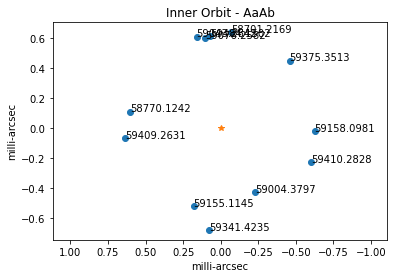

[False  True False False False  True  True  True  True  True  True  True]


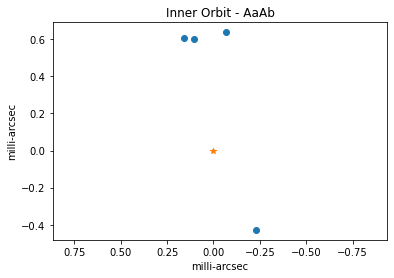

In [15]:
## plot inner components
plt.plot(xpos2,ypos2,'o')
try:
    plt.plot(xpos2[vlti_idx],ypos2[vlti_idx],'o')
except:
    pass
plt.plot(0,0,'*')

for d,xx,yy in zip(t,xpos2,ypos2):
    plt.annotate(d,xy=(xx,yy))
plt.title('Inner Orbit - AaAb')
plt.gca().set_xlabel('milli-arcsec')
plt.gca().set_ylabel('milli-arcsec')
plt.gca().invert_xaxis()
plt.gca().axis('equal')
plt.show()

## filter only best
#idx = [0,1,2,4,3,5,6,7,8,10]
idx = [0,2,3,4]
mask = np.ones(xpos2.shape,dtype=bool)
mask[idx]=False
print(mask)

plt.plot(xpos2[~mask],ypos2[~mask],'o')
plt.plot(0,0,'*')
plt.title('Inner Orbit - AaAb')
plt.gca().set_xlabel('milli-arcsec')
plt.gca().set_ylabel('milli-arcsec')
plt.gca().invert_xaxis()
plt.gca().axis('equal')
plt.show()

In [ ]:
idx = np.argsort(t)
for i,j,k,l,m,n in zip (t[idx],xpos2[idx],ypos2[idx],error_maj2[idx]/2.124,error_min2[idx]/2.124,error_deg2[idx]):
    pp,dd = cart2pol(j,k)
    print(i,pp,dd,l,m,n)

In [ ]:
## Run to use filtered inner data
#idx = [1,4]
mask = np.ones(xpos2.shape,dtype=bool)
mask[idx]=False
print(mask)

xpos2[mask]=np.nan
ypos2[mask]=np.nan
error_maj2[mask]=np.nan
error_min2[mask]=np.nan
error_pa2[mask]=np.nan
error_deg2[mask]=np.nan

print(xpos2)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 78
    # data points      = 24
    # variables        = 5
    chi-square         = 0.59873115
    reduced chi-square = 0.03151217
    Akaike info crit   = -78.5839147
    Bayesian info crit = -72.6936456
[[Variables]]
    w:           0 (fixed)
    bigw:        2.36869440 +/- 62756.4940 (2649412.86%) (init = 296)
    inc:         0.23523435 +/- 207.439564 (88184.22%) (init = 15)
    e:           0 (fixed)
    a:           0.63618608 +/- 0.74436911 (117.00%) (init = 0.6)
    P:           2.35797041 +/- 3.0118e-05 (0.00%) (init = 2.36)
    T:           53855.6435 +/- 411.082634 (0.76%) (init = 53853)
    mirc_scale:  1 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(bigw, T) =  1.000
    C(a, T)    =  1.000
    C(bigw, a) =  1.000
    C(a, P)    = -0.476
    C(P, T)    = -0.474
    C(bigw, P) = -0.474
    C(inc, P)  = -0.190
None


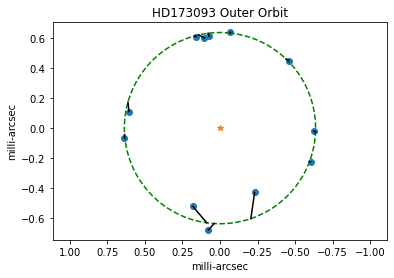

In [11]:
## quick look at INNER binary
#do fit, minimizer uses LM for least square fitting of model to data
params = Parameters()
params.add('w',   value= 0, vary=False)#min=0, max=360)
params.add('bigw', value= 296, min=0, max=360)
params.add('inc', value= 15, min=0, max=180)
params.add('e', value= 0, vary=False)#min=0, max=0.99)
params.add('a', value= 0.6, min=0)
params.add('P', value= 2.36, min=0)
params.add('T', value= 53853, min=0)
params.add('mirc_scale',value=1,vary=False)

minner = Minimizer(astrometry_model, params, fcn_args=(xpos2,ypos2,t,
                                        error_maj2,error_min2,error_pa2),
                                nan_policy='omit')
result = minner.minimize()

# write error report
print(report_fit(result))

## plot fit
scale=1
#if chi2_armada<1.0 and chi2_armada>0:
#    scale=1/np.sqrt(chi2_armada)
a_start = result.params['a']
P_start = result.params['P']
e_start = result.params['e']
inc_start = result.params['inc']
w_start = result.params['w']
bigw_start = result.params['bigw']
T_start = result.params['T']
mirc_scale_start = result.params['mirc_scale']

ra,dec,rapoints,decpoints = orbit_model(a_start,e_start,inc_start,
                                        w_start,bigw_start,P_start,
                                        T_start,t)
fig,ax=plt.subplots()
ax.plot(xpos2, ypos2, 'o')
ax.plot(0,0,'*')
ax.plot(ra, dec, '--',color='g')
#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos2[i],rapoints[i]]
    y=[ypos2[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Outer Orbit'%target_hd)
#plt.legend()
plt.show()

In [ ]:
for tt,xx,yy,ee1,ee2,ee3 in zip(t,xpos2,ypos2,error_maj2,error_min2,error_pa2):
    pp2,tt2 = cart2pol(xx,yy)
    print(tt,pp2,tt2,ee1,ee2,ee3)

## Run below cell for WDS file read-in

In [ ]:
###########################################
## Read in WDS data - and plot to check
###########################################
input_wds = 'y'
if input_wds == 'y':
    try:
        file=open(os.path.expanduser("%s/wds%s.txt"%(path_wds,target_wds)))
        weight = 10
        dtype = input('dtype for wds (e.g. S, leave blank for ALL data): ')

        t_wds,p_wds,theta_wds,error_maj_wds,error_min_wds,error_pa_wds,error_deg_wds = read_wds(file,weight,dtype)
        print('Number of WDS data points = %s'%len(p_wds))

        ## correct WDS for PA
        theta_wds -= (0.00557*np.sin(ra)/np.cos(dec)*((t_wds-51544.5)/365.25))/180*np.pi

        xpos_wds=p_wds*np.sin(theta_wds)
        ypos_wds=p_wds*np.cos(theta_wds)

        plt.plot(xpos_wds,ypos_wds,'o',label='WDS')
        plt.plot(xpos_wds[0],ypos_wds[0],'*')
        try:
            idx = np.argmin(t)
            plt.plot(xpos[idx],ypos[idx],'*')
            plt.plot(xpos,ypos,'+',label='ARMADA')
        except:
            pass
        plt.plot(0,0,'*')
        plt.gca().invert_xaxis()
        plt.title('All Data')
        plt.xlabel('dra (mas)')
        plt.ylabel('ddec (mas)')
        plt.legend()
        plt.show()

        flip = input('Flip WDS data? (y/n): ')
        if flip=='y':
            xpos_wds=-p_wds*np.sin(theta_wds)
            ypos_wds=-p_wds*np.cos(theta_wds)
            plt.plot(xpos_wds,ypos_wds,'o',label='WDS')
            plt.plot(xpos_wds[0],ypos_wds[0],'*')
            try:
                plt.plot(xpos[idx],ypos[idx],'*')
                plt.plot(xpos,ypos,'+',label='ARMADA')
            except:
                pass
            plt.plot(0,0,'*')
            plt.gca().invert_xaxis()
            plt.title('All Data')
            plt.xlabel('dra (mas)')
            plt.ylabel('ddec (mas)')
            plt.legend()
            plt.show()

            better = input('Flip data back to original? (y/n): ')
            if better=='y':
                xpos_wds=p_wds*np.sin(theta_wds)
                ypos_wds=p_wds*np.cos(theta_wds)
    except:
        t_wds = np.array([np.nan])
        p_wds = np.array([np.nan])
        theta_wds = np.array([np.nan])
        error_maj_wds = np.array([np.nan])
        error_min_wds = np.array([np.nan])
        error_pa_wds = np.array([np.nan])
        error_deg_wds = np.array([np.nan])
        xpos_wds=p_wds*np.sin(theta_wds)
        ypos_wds=p_wds*np.cos(theta_wds)
        print('NO WDS NUMBER')
else:
    t_wds = np.array([np.nan])
    p_wds = np.array([np.nan])
    theta_wds = np.array([np.nan])
    error_maj_wds = np.array([np.nan])
    error_min_wds = np.array([np.nan])
    error_pa_wds = np.array([np.nan])
    error_deg_wds = np.array([np.nan])
    xpos_wds=p_wds*np.sin(theta_wds)
    ypos_wds=p_wds*np.cos(theta_wds)
    print('NO WDS DATA')

## Run below cell for WDS from a previous fit

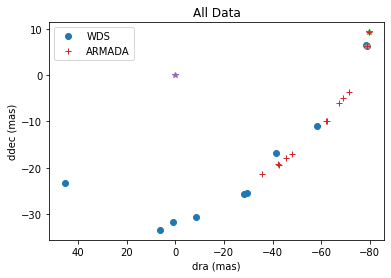

In [12]:
file_wds = open('/Users/tgardne/ARMADA_orbits/HD173093_chi2err/HD_173093_wds.txt')
p_wds=[]
degrees_wds=[]  #text file is in degrees
t_wds=[]
t_date_wds=[]
error_maj_wds=[]
error_min_wds=[]
error_pa_wds=[]
for line in file_wds.readlines():
    if line.startswith('#'):
        continue
    p_wds.append(float(line.split()[2]))
    degrees_wds.append(float(line.split()[3]))
    t_wds.append(float(line.split()[1]))
    t_date_wds.append(line.split()[0])
    if line.split()[4]=='--':
        error_maj_wds.append(0.1)
        error_min_wds.append(0.1)
        error_pa_wds.append(0)
    else:
        error_maj_wds.append(float(line.split()[4]))
        error_min_wds.append(float(line.split()[5]))
        epa = float(line.split()[6])
        #if epa>0:
        #    epa=90-epa
        #else:
        #    epa=abs(epa)+90
        error_pa_wds.append(epa)
file_wds.close()
degrees_wds=np.array(degrees_wds)
p_wds=np.array(p_wds)
t_wds=np.array(t_wds)
theta_wds=np.array(degrees_wds)*(np.pi/180)

error_maj_wds=weight*np.asarray(error_maj_wds)
error_min_wds=weight*np.asarray(error_min_wds)

error_deg_wds=np.asarray(error_pa_wds)
error_pa_wds=error_deg_wds*np.pi/180.

####################
## Plot to check:
####################
xpos_wds=p_wds*np.sin(theta_wds)
ypos_wds=p_wds*np.cos(theta_wds)
plt.plot(xpos_wds,ypos_wds,'o',label='WDS')
plt.plot(xpos_wds[0],ypos_wds[0],'*')
try:
    idx = np.argmin(t)
    plt.plot(xpos[idx],ypos[idx],'*')
    plt.plot(xpos,ypos,'+',label='ARMADA')
except:
    pass
plt.plot(0,0,'*')
plt.gca().invert_xaxis()
plt.title('All Data')
plt.xlabel('dra (mas)')
plt.ylabel('ddec (mas)')
plt.legend()
plt.show()

In [13]:
###########################################
## Get an estimate of the orbital parameters
###########################################
try:
    a,P,e,inc,omega,bigomega,T = read_orb6(target,path_orb6)
except:
    print('No elements found in ORB6. Will need to enter your own.')

self_params = 'y'
if self_params=='y':
    a = float(input('a (mas): '))
    P = float(input('P (year): '))*365.25
    e = float(input('ecc : '))
    inc = float(input('inc (deg): '))
    omega = float(input('omega (deg): '))
    bigomega = float(input('bigomega (deg): '))
    T = float(input('T (mjd): '))

found target!
--------------------------
a(mas),P(yr),e,i(deg),omega(deg),bigomega(deg),T(mjd)
78.7 13.520000000000001 0.124 112.1 290.2 97.6 52406.001592000015
--------------------------


a (mas):  75
P (year):  7
ecc :  0.6
inc (deg):  106
omega (deg):  249
bigomega (deg):  288
T (mjd):  58018


In [14]:
###########################################
## Combined WDS+ARMADA for fitting
###########################################
xpos_all = np.concatenate([xpos,xpos_wds])
ypos_all = np.concatenate([ypos,ypos_wds])
t_all = np.concatenate([t,t_wds])
error_maj_all = np.concatenate([error_maj,error_maj_wds])
error_min_all = np.concatenate([error_min,error_min_wds])
error_pa_all = np.concatenate([error_pa,error_pa_wds])
error_deg_all = np.concatenate([error_deg,error_deg_wds])

if vlti=='y':
    vlti_mask_all = np.ones(len(t_all),dtype=bool)
    vlti_mask_all[vlti_idx] = False

## Fit Outer Binary

In [15]:
##########################################
## Function for fitting/plotting data
#########################################
def ls_fit(params,xp,yp,tp,emaj,emin,epa):
    #do fit, minimizer uses LM for least square fitting of model to data
    if len(vlti_idx)>0:
        minner = Minimizer(astrometry_model_vlti, params, fcn_args=(xp[vlti_mask_all],yp[vlti_mask_all],tp[vlti_mask_all],
                                                        emaj[vlti_mask_all],emin[vlti_mask_all],epa[vlti_mask_all],
                                                        xp[vlti_idx],yp[vlti_idx],tp[vlti_idx],
                                                        emaj[vlti_idx],emin[vlti_idx],epa[vlti_idx]),
                                nan_policy='omit')
        result = minner.minimize()
    else:
        minner = Minimizer(astrometry_model, params, fcn_args=(xp,yp,tp,
                                                        emaj,emin,epa),
                                nan_policy='omit')
        result = minner.minimize()

    # write error report
    print(report_fit(result))

    resids_armada = astrometry_model(result.params,xpos,ypos,t,error_maj,
                                 error_min,error_pa)
    ndata_armada = 2*sum(~np.isnan(xpos))
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-7)
    print('-'*10)
    print('chi2 armada = %s'%chi2_armada)
    print('-'*10)

    ## plot fit
    scale=1
    if chi2_armada<1.0 and chi2_armada>0:
        scale=1/np.sqrt(chi2_armada)
    a_start = result.params['a']
    P_start = result.params['P']
    e_start = result.params['e']
    inc_start = result.params['inc']
    w_start = result.params['w']
    bigw_start = result.params['bigw']
    T_start = result.params['T']
    mirc_scale_start = result.params['mirc_scale']

    ra,dec,rapoints,decpoints = orbit_model(a_start,e_start,inc_start,
                                            w_start,bigw_start,P_start,
                                            T_start,t_all)
    fig,ax=plt.subplots()
    ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS')
    if len(vlti_idx)>0:
        ax.plot(xpos[vlti_idx]*mirc_scale_start,ypos[vlti_idx]*mirc_scale_start,'o', label='ARMADA-VLTI')
        ax.plot(xpos[vlti_mask],ypos[vlti_mask],'o', label='ARMADA-CHARA')
    else:
        ax.plot(xpos,ypos,'o', label='ARMADA')
    ax.plot(0,0,'*')
    ax.plot(ra, dec, '--',color='g')
    #plot lines from data to best fit orbit
    i=0
    while i<len(decpoints):
        x=[xpos_all[i],rapoints[i]]
        y=[ypos_all[i],decpoints[i]]
        ax.plot(x,y,color="black")
        i+=1
    ax.set_xlabel('milli-arcsec')
    ax.set_ylabel('milli-arcsec')
    ax.invert_xaxis()
    ax.axis('equal')
    ax.set_title('HD%s Outer Orbit'%target_hd)
    plt.legend()
    plt.show()

    return result

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 44
    # variables        = 7
    chi-square         = 125.265865
    reduced chi-square = 3.38556391
    Akaike info crit   = 60.0349455
    Bayesian info crit = 72.5242729
[[Variables]]
    w:           249.233786 +/- 6.08739577 (2.44%) (init = 249)
    bigw:        288.207976 +/- 0.60895783 (0.21%) (init = 288)
    inc:         106.356517 +/- 1.86427447 (1.75%) (init = 106)
    e:           0.56279819 +/- 0.04115607 (7.31%) (init = 0.6)
    a:           75.1477799 +/- 5.33005305 (7.09%) (init = 75)
    P:           2624.82094 +/- 69.2207850 (2.64%) (init = 2556.75)
    T:           58018.1438 +/- 84.7500705 (0.15%) (init = 58018)
    mirc_scale:  1 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(w, a)      =  0.998
    C(inc, a)    = -0.998
    C(w, inc)    = -0.993
    C(inc, T)    = -0.988
    C(a, T)      =  0.977
    C(w, T)      =  0.966
    C(e, T)     

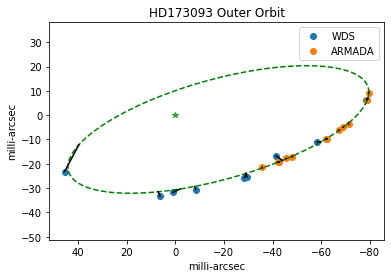

In [16]:
params = Parameters()
params.add('w',   value= omega, min=0, max=360)
params.add('bigw', value= bigomega, min=0, max=360)
params.add('inc', value= inc, min=0, max=180)
params.add('e', value= e, min=0, max=0.99)
params.add('a', value= a, min=0)
params.add('P', value= P, min=0)
params.add('T', value= T, min=0)
if len(vlti_idx)>0:
    params.add('mirc_scale', value=1)
else:
    params.add('mirc_scale',value=1,vary=False)

result = ls_fit(params,xpos_all,ypos_all,t_all,error_maj_all,error_min_all,error_pa_all)

----------
chi2 armada = 7.255808768616307
----------


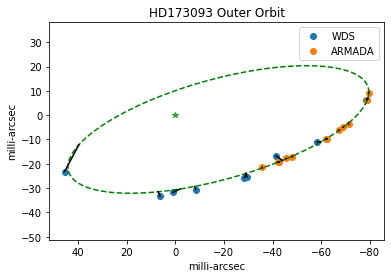

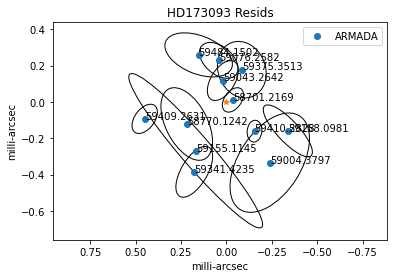

----------
Mean residual = 275.32 micro-as
----------


In [17]:
##########################################
## Save Plots
##########################################
if len(vlti_idx)>0:
    resids_armada = astrometry_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],
                                xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],
                                error_maj[vlti_idx],error_min[vlti_idx],error_pa[vlti_idx])
else:
    resids_armada = astrometry_model(result.params,xpos,ypos,t,error_maj,
                                error_min,error_pa)
ndata_armada = 2*sum(~np.isnan(xpos))
chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-7)
print('-'*10)
print('chi2 armada = %s'%chi2_armada)
print('-'*10)

directory='%s/HD%s_chi2err_triple/'%(path,target_hd)
if not os.path.exists(directory):
    os.makedirs(directory)

## plot fit
scale=1
if chi2_armada<1.0 and chi2_armada>0:
    scale=1/np.sqrt(chi2_armada)
a_start = result.params['a']
P_start = result.params['P']
e_start = result.params['e']
inc_start = result.params['inc']
w_start = result.params['w']
bigw_start = result.params['bigw']
T_start = result.params['T']
mirc_scale_start = result.params['mirc_scale']
ra,dec,rapoints,decpoints = orbit_model(a_start,e_start,inc_start,
                                        w_start,bigw_start,P_start,
                                        T_start,t_all)
fig,ax=plt.subplots()
ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS')
if len(vlti_idx)>0:
    ax.plot(xpos[vlti_idx]*mirc_scale_start,ypos[vlti_idx]*mirc_scale_start,'o', label='ARMADA-VLTI')
    ax.plot(xpos[vlti_mask],ypos[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xpos,ypos,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra, dec, '--',color='g')
#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos_all[i],rapoints[i]]
    y=[ypos_all[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Outer Orbit'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_outer_binary.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## plot resids for ARMADA
fig,ax=plt.subplots()
if len(vlti_idx)>0:
    xresid_vlti = xpos[vlti_idx]*mirc_scale_start - rapoints[:len(xpos)][vlti_idx]
    yresid_vlti = ypos[vlti_idx]*mirc_scale_start - decpoints[:len(ypos)][vlti_idx]
    xresid_chara = xpos[vlti_mask] - rapoints[:len(xpos)][vlti_mask]
    yresid_chara = ypos[vlti_mask] - decpoints[:len(ypos)][vlti_mask]
    xresid = np.concatenate([xresid_chara,xresid_vlti])
    yresid = np.concatenate([yresid_chara,yresid_vlti])
else:
    xresid = xpos - rapoints[:len(xpos)]
    yresid = ypos - decpoints[:len(ypos)]

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle, d in zip(xresid,yresid,error_maj/scale,error_min/scale,error_deg,t):
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                      angle=90-angle, facecolor='none', edgecolor='black')
    ax.annotate(d,xy=(ras,decs))
    ax.add_patch(ellipse)

if len(vlti_idx)>0:
    ax.plot(xresid[vlti_idx],yresid[vlti_idx],'o', label='ARMADA-VLTI')
    ax.plot(xresid[vlti_mask],yresid[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xresid,yresid,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Resids'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_resid_binary.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## residuals
resids = np.sqrt(xresid**2 + yresid**2)
resids_median = np.around(np.median(resids)*1000,2)
print('-'*10)
print('Mean residual = %s micro-as'%resids_median)
print('-'*10)

## Save txt file with best orbit
f = open("%s/%s_%s_orbit_binary.txt"%(directory,target_hd,note),"w+")
f.write("# P(d) a(mas) e i(deg) w(deg) W(deg) T(mjd) mirc_scale mean_resid(mu-as)\r\n")
f.write("%s %s %s %s %s %s %s %s %s"%(P_start.value,a_start.value,e_start.value,
                                   inc_start.value*180/np.pi,w_start.value*180/np.pi,
                                   bigw_start.value*180/np.pi,T_start.value,
                                  mirc_scale_start.value,resids_median))
f.close()

## Run below cell for TRIPLE + RV Fit:

In [21]:
## Try a quad fit -- giving two orbital periods
## Do a fit at best period

P2_best = []
a2_best = []
a_inner_best = []
e2_best = []
w2_best = []
bigw2_best = []
inc2_best = []
T2_best = []

P_best = []
a_best = []
e_best = []
w_best = []
bigw_best = []
inc_best = []
T_best = []
mirc_scale_best = []
chi2_results = []

K_a_best = []
K_aa_best = []
K_ab_best = []
K_b_best = []
#K_best = []
gamma_best = []
#gamma2_best = []
#gamma3_best = []
#gamma4_best = []

circular = 'y'
P2_guess = 2.36
i2_guess = 15
a2_guess = 0.3
a_inner_guess = -0.6

K_aa_guess = 24
K_ab_guess = 20
K_a_guess = 10
K_b_guess = 30
gamma_guess = -50

include_rv = 'y'

for i in tqdm(np.arange(100)):
    bigw2 = random.uniform(0,360)
    #bigw2 = 107
    T2 = random.uniform(np.median(t_rv_aa),max(t_rv_aa))
    #T2 = 55058.9
    if i2_guess == 'n':
        inc2 = random.uniform(0,180)
    else:
        inc2 = i2_guess
        
    if circular!='y':
        e2 = random.uniform(0,0.99)
        w2 = random.uniform(0,360)
        
    params = Parameters()
    params.add('w',   value = omega, min=0, max=360)
    params.add('bigw', value = bigomega, min=0, max=360)
    params.add('inc', value = inc, min=0, max=180)
    params.add('e', value = e, min=0, max=0.99)
    params.add('a', value = a, min=0)
    params.add('P', value = P, min=0)
    params.add('T', value = T, min=0)

    if circular!='y':
        params.add('w2',   value= w2, min=0, max=360)
        params.add('e2', value= e2, min=0,max=0.99)
    else:
        params.add('w2',   value= 0, vary=False)
        params.add('e2', value= 0, vary=False)
        
    params.add('bigw2', value= bigw2, min=0, max=360)
    params.add('inc2', value= inc2, min=0, max=180)
    params.add('a2', value= a2_guess, min=0)
    params.add('a_inner', value= a_inner_guess)
    params.add('P2', value= P2_guess, min=0)
    params.add('T2', value= T2, min=0)

    if include_rv=='y':
        params.add('K_aa', value= K_aa_guess)
        params.add('K_ab', value= K_ab_guess)
        params.add('K_a', value= K_a_guess)
        params.add('K_b', value= K_b_guess)
        #params.add('K', value = K_aa_guess)
        params.add('gamma', value= gamma_guess)
        
        ## more params for hd1976 case
        #params.add('gamma2', value= gamma_guess)
        #params.add('gamma3', value= gamma_guess)
        #params.add('gamma4', value= gamma_guess)

    if len(vlti_idx)>0:
        params.add('mirc_scale', value=1)
    else:
        params.add('mirc_scale',value=1,vary=False)

    #params.add('pscale', value=1)

    #do fit, minimizer uses LM for least square fitting of model to data
    if len(vlti_idx)>0:
        if include_rv=='y':
            #minner = Minimizer(triple_model_vlti_combined, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
            #                                                    error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
            #                                                    error_pa_all[vlti_mask_all],
            #                                                    xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
            #                                                    error_maj_all[vlti_idx],error_min_all[vlti_idx],
            #                                                    error_pa_all[vlti_idx],rv,t_rv,err_rv),
            #                    nan_policy='omit')
            #result = minner.minimize()
            minner = Minimizer(triple_model_full_vlti_combined, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                                error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                                error_pa_all[vlti_mask_all],
                                                                xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                                error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                                error_pa_all[vlti_idx],
                                                                             xpos2[vlti_mask],ypos2[vlti_mask],t[vlti_mask],
                                                                error_maj2[vlti_mask],error_min2[vlti_mask],
                                                                error_pa2[vlti_mask],
                                                                xpos2[vlti_idx],ypos2[vlti_idx],t[vlti_idx],
                                                                error_maj2[vlti_idx],error_min2[vlti_idx],
                                                                error_pa2[vlti_idx],
                                                                             rv_aa,t_rv_aa,err_rv_aa),
                                nan_policy='omit')
            result = minner.minimize()
        else:
            minner = Minimizer(triple_model_full_vlti, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                                error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                                error_pa_all[vlti_mask_all],
                                                                xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                                error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                                error_pa_all[vlti_idx],
                                                                             xpos2[vlti_mask],ypos2[vlti_mask],t[vlti_mask],
                                                                error_maj2[vlti_mask],error_min2[vlti_mask],
                                                                error_pa2[vlti_mask],
                                                                xpos2[vlti_idx],ypos2[vlti_idx],t[vlti_idx],
                                                                error_maj2[vlti_idx],error_min2[vlti_idx],
                                                                error_pa2[vlti_idx]),
                                nan_policy='omit')
            result = minner.minimize()
    else:
        if include_rv=='y':
            minner = Minimizer(triple_model_combined3, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                                error_maj_all,error_min_all,
                                                                error_pa_all, xpos2,ypos2,t,
                                                                error_maj2,error_min2,
                                                                error_pa2,rv_aa,t_rv_aa,err_rv_aa,
                                                                rv_ab,t_rv_ab,err_rv_ab,
                                                                rv_b,t_rv_b,err_rv_b),
                                nan_policy='omit')
            result = minner.minimize()
            
            #minner = Minimizer(triple_model_full_combined, params, fcn_args=(xpos_all,ypos_all,t_all,
            #                                                    error_maj_all,error_min_all,
            #                                                    error_pa_all, xpos2,ypos2,t,
            #                                                    error_maj2,error_min2,
            #                                                    error_pa2,rv_aa,t_rv_aa,err_rv_aa),
            #                    nan_policy='omit')
            #result = minner.minimize()
            
            ##special hd1976 case:
            #minner = Minimizer(triple_model_full_combined_hd1976, params, fcn_args=(xpos_all,ypos_all,t_all,
            #                                                    error_maj_all,error_min_all,
            #                                                    error_pa_all, xpos2,ypos2,t,
            #                                                    error_maj2,error_min2,
            #                                                    error_pa2,rv_aa,t_rv_aa,err_rv_aa,
            #                                                                       rv_aa2,t_rv_aa2,err_rv_aa2,
            #                                                                       rv_aa3,t_rv_aa3,err_rv_aa3,
            #                                                                       rv_aa4,t_rv_aa4,err_rv_aa4),
            #                    nan_policy='omit')
            #result = minner.minimize()
        else:
            minner = Minimizer(triple_model_full, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                                error_maj_all,error_min_all,
                                                                error_pa_all, xpos2,ypos2,t,
                                                                error_maj2,error_min2,
                                                                error_pa2),
                                nan_policy='omit')
            result = minner.minimize()

    P2_best.append(result.params['P2'])
    a2_best.append(result.params['a2'])
    a_inner_best.append(result.params['a_inner'])
    e2_best.append(result.params['e2'])
    w2_best.append(result.params['w2'])
    bigw2_best.append(result.params['bigw2'])
    inc2_best.append(result.params['inc2'])
    T2_best.append(result.params['T2'])

    P_best.append(result.params['P'])
    a_best.append(result.params['a'])
    e_best.append(result.params['e'])
    w_best.append(result.params['w'])
    bigw_best.append(result.params['bigw'])
    inc_best.append(result.params['inc'])
    T_best.append(result.params['T'])

    mirc_scale_best.append(result.params['mirc_scale'])
    chi2_results.append(result.redchi)
    
    if include_rv=='y':
        K_aa_best.append(result.params['K_aa'])
        K_ab_best.append(result.params['K_ab'])
        K_a_best.append(result.params['K_a'])
        K_b_best.append(result.params['K_b'])
        #K_best.append(result.params['K'])
        gamma_best.append(result.params['gamma'])
        
        ##hd1976
        #gamma2_best.append(result.params['gamma2'])
        #gamma3_best.append(result.params['gamma3'])
        #gamma4_best.append(result.params['gamma4'])

100%|██████████| 100/100 [16:03<00:00,  9.63s/it]


In [22]:
P2_best = np.array(P2_best)
a2_best = np.array(a2_best)
a_inner_best = np.array(a_inner_best)
e2_best = np.array(e2_best)
w2_best = np.array(w2_best)
bigw2_best = np.array(bigw2_best)
inc2_best = np.array(inc2_best)
T2_best = np.array(T2_best)

P_best = np.array(P_best)
a_best = np.array(a_best)
e_best = np.array(e_best)
w_best = np.array(w_best)
bigw_best = np.array(bigw_best)
inc_best = np.array(inc_best)
T_best = np.array(T_best)
mirc_scale_best = np.array(mirc_scale_best)
chi2_results = np.array(chi2_results)

if include_rv=='y':
    K_aa_best = np.array(K_aa_best)
    K_ab_best = np.array(K_ab_best)
    K_a_best = np.array(K_a_best)
    K_b_best = np.array(K_b_best)
    #K_best = np.array(K_best)
    gamma_best = np.array(gamma_best)

idx = np.argmin(chi2_results)
P2_best = P2_best[idx]
a2_best = a2_best[idx]
a_inner_best = a_inner_best[idx]
e2_best = e2_best[idx]
w2_best = w2_best[idx]
bigw2_best = bigw2_best[idx]
inc2_best = inc2_best[idx]
T2_best = T2_best[idx]

P_best = P_best[idx]
a_best = a_best[idx]
e_best = e_best[idx]
w_best = w_best[idx]
bigw_best = bigw_best[idx]
inc_best = inc_best[idx]
T_best = T_best[idx]
mirc_scale_best = mirc_scale_best[idx]

if include_rv=='y':
    K_aa_best = K_aa_best[idx]
    K_ab_best = K_ab_best[idx]
    K_a_best = K_a_best[idx]
    K_b_best = K_b_best[idx]
    #K_best = K_best[idx]
    gamma_best = gamma_best[idx]
    
    ##hd1976 case
    #gamma2_best = gamma2_best[idx]
    #gamma3_best = gamma3_best[idx]
    #gamma4_best = gamma4_best[idx]

In [24]:
## Save a fit for errors
circular = 'y'

params = Parameters()
params.add('w',   value = w_best, min=0, max=360)
params.add('bigw', value = bigw_best, min=0, max=360)
params.add('inc', value = inc_best, min=0, max=180)
params.add('e', value = e_best, min=0, max=0.99)
params.add('a', value = a_best, min=0)
params.add('P', value = P_best, min=0)
params.add('T', value = T_best, min=0)

if circular!='y':
    params.add('w2',   value= w2_best, min=0, max=360)
    params.add('e2', value= e2_best, min=0,max=0.99)
else:
    params.add('w2',   value= 0, vary=False)
    params.add('e2', value= 0, vary=False)
        
params.add('bigw2', value= bigw2_best, min=0, max=360)
params.add('inc2', value= inc2_best, min=0, max=180)
params.add('a2', value= a2_best, min=0)
params.add('a_inner', value= a_inner_best)
params.add('P2', value= P2_best, min=0)
params.add('T2', value= T2_best, min=0)

if include_rv=='y':
    params.add('K_aa', value= K_aa_best)
    params.add('K_ab', value= K_ab_best)
    params.add('K_a', value= K_a_best)
    params.add('K_b', value= K_b_best)
    #params.add('K', value= K_best)
    params.add('gamma', value= gamma_best)
    #params.add('gamma2', value= gamma2_best)
    #params.add('gamma3', value= gamma3_best)
    #params.add('gamma4', value= gamma4_best)

if len(vlti_idx)>0:
    params.add('mirc_scale', value=mirc_scale_best)
else:
    params.add('mirc_scale',value=1,vary=False)

#params.add('pscale', value=1)

#do fit, minimizer uses LM for least square fitting of model to data
if include_rv=='y':
    if len(vlti_idx)>0:
        #minner = Minimizer(triple_model_vlti_combined, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
        #                                                    error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
        #                                                    error_pa_all[vlti_mask_all],
        #                                                    xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
        #                                                    error_maj_all[vlti_idx],error_min_all[vlti_idx],
        #                                                    error_pa_all[vlti_idx],rv,t_rv,err_rv),
        #                    nan_policy='omit')
        #result = minner.minimize()
        minner = Minimizer(triple_model_full_vlti_combined, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                                error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                                error_pa_all[vlti_mask_all],
                                                                xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                                error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                                error_pa_all[vlti_idx],
                                                                             xpos2[vlti_mask],ypos2[vlti_mask],t[vlti_mask],
                                                                error_maj2[vlti_mask],error_min2[vlti_mask],
                                                                error_pa2[vlti_mask],
                                                                xpos2[vlti_idx],ypos2[vlti_idx],t[vlti_idx],
                                                                error_maj2[vlti_idx],error_min2[vlti_idx],
                                                                error_pa2[vlti_idx],
                                                                             rv_aa,t_rv_aa,err_rv_aa),
                                nan_policy='omit')
        result = minner.minimize()
    else:
        minner = Minimizer(triple_model_combined3, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                            error_maj_all,error_min_all,
                                                            error_pa_all,xpos2,ypos2,t,
                                                            error_maj2,error_min2,
                                                            error_pa2,rv_aa,t_rv_aa,err_rv_aa,
                                                                    rv_ab,t_rv_ab,err_rv_ab,
                                                                    rv_b,t_rv_b,err_rv_b),
                            nan_policy='omit')
        result = minner.minimize()
        
        #minner = Minimizer(triple_model_full_combined, params, fcn_args=(xpos_all,ypos_all,t_all,
        #                                                    error_maj_all,error_min_all,
        #                                                    error_pa_all,xpos2,ypos2,t,
        #                                                    error_maj2,error_min2,
        #                                                    error_pa2,rv_aa,t_rv_aa,err_rv_aa),
        #                    nan_policy='omit')
        #result = minner.minimize()
        
        ##hd1976 case:
        #minner = Minimizer(triple_model_full_combined_hd1976, params, fcn_args=(xpos_all,ypos_all,t_all,
        #                                                    error_maj_all,error_min_all,
        #                                                    error_pa_all,xpos2,ypos2,t,
        #                                                    error_maj2,error_min2,
        #                                                    error_pa2,rv_aa,t_rv_aa,err_rv_aa,
        #                                                                rv_aa2,t_rv_aa2,err_rv_aa2,
        #                                                                rv_aa3,t_rv_aa3,err_rv_aa3,
        #                                                                rv_aa4,t_rv_aa4,err_rv_aa4),
        #                    nan_policy='omit')
        #result = minner.minimize()
else:
    if len(vlti_idx)>0:
        minner = Minimizer(triple_model_full_vlti, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                                error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                                error_pa_all[vlti_mask_all],
                                                                xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                                error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                                error_pa_all[vlti_idx],
                                                                             xpos2[vlti_mask],ypos2[vlti_mask],t[vlti_mask],
                                                                error_maj2[vlti_mask],error_min2[vlti_mask],
                                                                error_pa2[vlti_mask],
                                                                xpos2[vlti_idx],ypos2[vlti_idx],t[vlti_idx],
                                                                error_maj2[vlti_idx],error_min2[vlti_idx],
                                                                error_pa2[vlti_idx]),
                                nan_policy='omit')
        result = minner.minimize()
    else:
        minner = Minimizer(triple_model_full, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                            error_maj_all,error_min_all,
                                                            error_pa_all,xpos2,ypos2,t,
                                                            error_maj2,error_min2,
                                                            error_pa2),
                            nan_policy='omit')
        result = minner.minimize()

report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 20
    # data points      = 1011
    # variables        = 18
    chi-square         = 1199.56171
    reduced chi-square = 1.20801784
    Akaike info crit   = 208.897491
    Bayesian info crit = 297.434005
[[Variables]]
    w:           255.554513 +/- 0.12672333 (0.05%) (init = 255.5545)
    bigw:        287.884579 +/- 0.08407575 (0.03%) (init = 287.8846)
    inc:         104.272143 +/- 0.04826951 (0.05%) (init = 104.2721)
    e:           0.60676901 +/- 0.00124984 (0.21%) (init = 0.606769)
    a:           81.9322927 +/- 0.16717909 (0.20%) (init = 81.93229)
    P:           2638.31878 +/- 1.47356635 (0.06%) (init = 2638.319)
    T:           58109.7779 +/- 1.75525504 (0.00%) (init = 58109.78)
    w2:          0 (fixed)
    e2:          0 (fixed)
    bigw2:       297.579522 +/- 3.07237005 (1.03%) (init = 297.5795)
    inc2:        2.12802674 +/- 150.505328 (7072.53%) (init = 2.128027)
    a2:          0.0053349

In [24]:
## scale errors based on chi2
if len(vlti_idx)>0:
    resids_armada = triple_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],
                                xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],error_maj[vlti_idx],
                                error_min[vlti_idx],error_pa[vlti_idx])
    resids_chara = triple_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],[],[],[],[],[],[])
    resids_vlti = triple_model_vlti(result.params,[],[],[],[],[],[],xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],error_maj[vlti_idx],
                                error_min[vlti_idx],error_pa[vlti_idx])
    
    
    resids_wds = triple_model(result.params,xpos_all[len(error_maj):],ypos_all[len(error_maj):],t_all[len(error_maj):],error_maj_all[len(error_maj):],
                                error_min_all[len(error_maj):],error_pa_all[len(error_maj):])
    ndata_wds = 2*sum(~np.isnan(xpos_all[:len(error_maj)]))
    
    ndata_armada = 2*sum(~np.isnan(xpos))
    ndata_chara = 2*sum(~np.isnan(xpos[vlti_mask]))
    ndata_vlti = 2*sum(~np.isnan(xpos[vlti_idx]))
else:
    resids_armada = triple_model(result.params,xpos,ypos,t,error_maj,
                                error_min,error_pa)
    ndata_armada = 2*sum(~np.isnan(xpos))
    
    resids_wds = triple_model(result.params,xpos_all[len(error_maj):],ypos_all[len(error_maj):],t_all[len(error_maj):],error_maj_all[len(error_maj):],
                                error_min_all[len(error_maj):],error_pa_all[len(error_maj):])
    ndata_wds = 2*sum(~np.isnan(xpos_all[:len(error_maj)]))

if circular=='y':
    print(ndata_armada)
    print(len(result.params))
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-12)
    chi2_wds = np.nansum(resids_wds**2)/(ndata_wds-12)
    try:
        chi2_chara = np.nansum(resids_chara**2)/(ndata_chara-12)
        chi2_vlti = np.nansum(resids_vlti**2)/(ndata_vlti-12)
    except:
        pass
else:
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-14)
    chi2_wds = np.nansum(resids_wds**2)/(ndata_wds-14)
    try:
        chi2_chara = np.nansum(resids_chara**2)/(ndata_chara-14)
        chi2_vlti = np.nansum(resids_vlti**2)/(ndata_vlti-14)
    except:
        pass
    
    
print('-'*10)
print('chi2 wds = %s'%chi2_wds)
print('-'*10)

print('-'*10)
print('chi2 armada = %s'%chi2_armada)
print('-'*10)

try:
    print('-'*10)
    print('chi2 chara = %s'%chi2_chara)
    print('-'*10)
    
    print('-'*10)
    print('chi2 vlti = %s'%chi2_vlti)
    print('-'*10)
except:
    pass

24
21
----------
chi2 wds = 0.92489415918483
----------
----------
chi2 armada = 16.52138046071546
----------
----------


In [ ]:
1/np.sqrt(0.8)

In [20]:
## scale errors
armada_scale = 1
armada_inner_scale = 1
vlti_scale = 1
chara_scale = 1
wds_scale = 1/np.sqrt(0.03)

if len(vlti_idx)>0:
    error_maj[vlti_idx]/=vlti_scale
    error_min[vlti_idx]/=vlti_scale
    error_maj_all[vlti_idx]/=vlti_scale
    error_min_all[vlti_idx]/=vlti_scale
    
    error_maj[vlti_mask]/=chara_scale
    error_min[vlti_mask]/=chara_scale
    error_maj_all[vlti_mask_all]/=chara_scale
    error_min_all[vlti_mask_all]/=chara_scale
    
    error_maj2/=armada_inner_scale
    error_min2/=armada_inner_scale
    
else:
    error_maj/=armada_scale
    error_min/=armada_scale
    error_maj2/=armada_scale
    error_min2/=armada_scale
    
    #error_maj_wds/=wds_scale
    #error_min_wds/=wds_scale
    
    error_maj_all[:len(error_maj)]/=armada_scale
    error_min_all[:len(error_maj)]/=armada_scale
    error_maj2/=armada_inner_scale
    error_min2/=armada_inner_scale
    error_maj_all[len(error_maj):]/=wds_scale
    error_min_all[len(error_maj):]/=wds_scale

In [ ]:
## Save a fit for errors
params = Parameters()
params.add('w',   value = w_best, min=0, max=360)
params.add('bigw', value = bigw_best, min=0, max=360)
params.add('inc', value = inc_best, min=0, max=180)
params.add('e', value = e_best, min=0, max=0.99)
params.add('a', value = a_best, min=0)
params.add('P', value = P_best, min=0)
params.add('T', value = T_best, min=0)

if circular!='y':
    params.add('w2',   value= w2_best, min=0, max=360)
    params.add('e2', value= e2_best, min=0,max=0.99)
else:
    params.add('w2',   value= 0, vary=False)
    params.add('e2', value= 0, vary=False)
        
params.add('bigw2', value= bigw2_best, min=0, max=360)
params.add('inc2', value= inc2_best, min=0, max=180)
params.add('a2', value= a2_best, min=0)
params.add('a_inner', value= a_inner_best)
params.add('P2', value= P2_best, min=0)
params.add('T2', value= T2_best, min=0)

if include_rv=='y':
    params.add('K_aa', value= K_aa_best, min=0)
    params.add('K_ab', value= K_ab_best, min=0)
    params.add('K_a', value= K_a_best, min=0)
    params.add('K_b', value= K_b_best, min=0)
    #params.add('K', value= K_best)
    params.add('gamma', value= gamma_best)
    ##hd1976
    #params.add('gamma2', value= gamma_best)
    #params.add('gamma3', value= gamma_best)
    #params.add('gamma4', value= gamma_best)

if len(vlti_idx)>0:
    params.add('mirc_scale', value=mirc_scale_best)
else:
    params.add('mirc_scale',value=1,vary=False)

#params.add('pscale', value=1)

#do fit, minimizer uses LM for least square fitting of model to data
if include_rv=='y':
    if len(vlti_idx)>0:
        minner = Minimizer(triple_model_vlti_combined, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                            error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                            error_pa_all[vlti_mask_all],
                                                            xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                            error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                            error_pa_all[vlti_idx],rv,t_rv,err_rv),
                            nan_policy='omit')
        result = minner.minimize()
    else:
        minner = Minimizer(triple_model_combined3, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                            error_maj_all,error_min_all,
                                                            error_pa_all,xpos2,ypos2,t,
                                                            error_maj2,error_min2,
                                                            error_pa2,rv_aa,t_rv_aa,err_rv_aa,
                                                                    rv_ab,t_rv_ab,err_rv_ab,
                                                                    rv_b,t_rv_b,err_rv_b),
                            nan_policy='omit')
        result = minner.minimize()
        
        #minner = Minimizer(triple_model_full_combined, params, fcn_args=(xpos_all,ypos_all,t_all,
        #                                                    error_maj_all,error_min_all,
        #                                                    error_pa_all,xpos2,ypos2,t,
        #                                                    error_maj2,error_min2,
        #                                                    error_pa2,rv_aa,t_rv_aa,err_rv_aa),
        #                    nan_policy='omit')
        #result = minner.minimize()
        
        ##hd1976
        #minner = Minimizer(triple_model_full_combined_hd1976, params, fcn_args=(xpos_all,ypos_all,t_all,
        #                                                    error_maj_all,error_min_all,
        #                                                    error_pa_all,xpos2,ypos2,t,
        #                                                    error_maj2,error_min2,
        #                                                    error_pa2,rv_aa,t_rv_aa,err_rv_aa,
        #                                                                       rv_aa2,t_rv_aa2,err_rv_aa2,
        #                                                                       rv_aa3,t_rv_aa3,err_rv_aa3,
        #                                                                       rv_aa4,t_rv_aa4,err_rv_aa4),
        #                    nan_policy='omit')
        #result = minner.minimize()
else:
    if len(vlti_idx)>0:
        minner = Minimizer(triple_model_full_vlti, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                                error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                                error_pa_all[vlti_mask_all],
                                                                xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                                error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                                error_pa_all[vlti_idx],
                                                                             xpos2[vlti_mask],ypos2[vlti_mask],t[vlti_mask],
                                                                error_maj2[vlti_mask],error_min2[vlti_mask],
                                                                error_pa2[vlti_mask],
                                                                xpos2[vlti_idx],ypos2[vlti_idx],t[vlti_idx],
                                                                error_maj2[vlti_idx],error_min2[vlti_idx],
                                                                error_pa2[vlti_idx]),
                                nan_policy='omit')
        result = minner.minimize()
    else:
        minner = Minimizer(triple_model_full, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                            error_maj_all,error_min_all,
                                                            error_pa_all,xpos2,ypos2,t,
                                                            error_maj2,error_min2,
                                                            error_pa2),
                            nan_policy='omit')
        result = minner.minimize()

report_fit(result)

P2_best = result.params['P2'].value
a2_best = result.params['a2'].value
a_inner_best = result.params['a_inner'].value
e2_best = result.params['e2'].value
w2_best = result.params['w2'].value
bigw2_best = result.params['bigw2'].value
inc2_best = result.params['inc2'].value
T2_best = result.params['T2'].value

P_best = result.params['P'].value
a_best = result.params['a'].value
e_best = result.params['e'].value
w_best = result.params['w'].value
bigw_best = result.params['bigw'].value
inc_best = result.params['inc'].value
T_best = result.params['T'].value
mirc_scale_best = result.params['mirc_scale'].value

if include_rv=='y':
    K_aa_best = result.params['K_aa'].value
    K_ab_best = result.params['K_ab'].value
    K_a_best = result.params['K_a'].value
    K_b_best = result.params['K_b'].value
    #K_best = result.params['K'].value
    gamma_best = result.params['gamma'].value
    #gamma2_best = result.params['gamma2'].value
    #gamma3_best = result.params['gamma3'].value
    #gamma4_best = result.params['gamma4'].value

24
21
----------
chi2 armada = 28.322366504083647
----------


scale errors by:  1


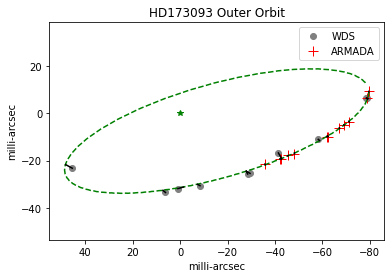

In [25]:
##########################################
## Save Plots for Triple
##########################################
if len(vlti_idx)>0:
    resids_armada = triple_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],
                                xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],
                                error_maj[vlti_idx],error_min[vlti_idx],error_pa[vlti_idx])
else:
    resids_armada = triple_model(result.params,xpos,ypos,t,error_maj,
                                error_min,error_pa)
ndata_armada = 2*sum(~np.isnan(xpos))

if circular=='y':
    print(ndata_armada)
    print(len(result.params))
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-17)
else:
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-19)
    
print('-'*10)
print('chi2 armada = %s'%chi2_armada)
print('-'*10)

if len(vlti_idx)>0:
    xpos[vlti_idx]*=mirc_scale_best
    ypos[vlti_idx]*=mirc_scale_best
    xpos_all[vlti_idx]*=mirc_scale_best
    ypos_all[vlti_idx]*=mirc_scale_best
else:
    idx = np.where(t<58757)
    xpos[idx]/=mirc_scale_best
    ypos[idx]/=mirc_scale_best
    idx = np.where(t_all<58757)
    xpos_all[idx]/=mirc_scale_best
    ypos_all[idx]/=mirc_scale_best

## plot fit
scale=1
if chi2_armada<1.0 and chi2_armada>0:
    scale=1/np.sqrt(chi2_armada)
else:
    scale=float(input('scale errors by: '))

tmodel = np.linspace(t_all[0],t_all[0]+P,1000)
ra,dec,rapoints,decpoints = triple_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,
                                        t_all,tmodel)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all,tmodel)

fig,ax=plt.subplots()
ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS',color='grey')
if len(vlti_idx)>0:
    ax.plot(xpos[vlti_idx],ypos[vlti_idx],'*', label='ARMADA-VLTI',color='red')
    ax.plot(xpos[vlti_mask],ypos[vlti_mask],'+', label='ARMADA-CHARA',color='blue')
else:
    ax.plot(xpos,ypos,'+', label='ARMADA',color='red',markersize=10)
ax.plot(0,0,'*',color='g')
ax.plot(ra, dec, '--',color='g')

#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos_all[i],rapoints[i]]
    y=[ypos_all[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Outer Orbit'%target_hd)
ax.legend()
plt.savefig('%s/HD%s_%s_outer_triple.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

Scale for triple =  1


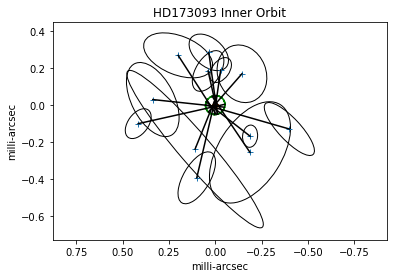

0.35128202593682495


In [26]:
## plot inner wobble
#idx = np.where(error_maj/scale<1)

tmodel = np.linspace(t[0],t[0]+3*P2_best,1000)
ra,dec,rapoints,decpoints = triple_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,
                                        t_all,tmodel)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all,tmodel)

ra_inner = ra - ra2
dec_inner = dec - dec2
rapoints_inner = rapoints - rapoints2
decpoints_inner = decpoints - decpoints2

xpos_inner = xpos_all - rapoints2
ypos_inner = ypos_all - decpoints2

fig,ax=plt.subplots()
if len(vlti_idx)>0:
    ax.plot(xpos_inner[:len(xpos)][vlti_idx],ypos_inner[:len(xpos)][vlti_idx],'+', label='ARMADA-VLTI')
    ax.plot(xpos_inner[:len(xpos)][vlti_mask],ypos_inner[:len(xpos)][vlti_mask],'+', label='ARMADA-CHARA')
else:
    ax.plot(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],'+', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra_inner, dec_inner, '--',color='g')

#need to measure error ellipse angle east of north
scale = float(input('Scale for triple = '))
for ras, decs, w, h, angle in zip(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],error_maj/scale,error_min/scale,error_deg):
    #if w<0.05:
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                        angle=90-angle, facecolor='none', edgecolor='black')
    ax.add_patch(ellipse)

#plot lines from data to best fit orbit
i=0
while i<len(decpoints_inner[:len(xpos)]):
    x=[xpos_inner[:len(xpos)][i],rapoints_inner[:len(xpos)][i]]
    y=[ypos_inner[:len(xpos)][i],decpoints_inner[:len(xpos)][i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Inner Orbit'%target_hd)
#plt.legend()
plt.savefig('%s/HD%s_%s_inner_triple.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

residuals = np.sqrt((xpos_inner[:len(xpos)] - rapoints_inner[:len(xpos)])**2 + (ypos_inner[:len(xpos)]-decpoints_inner[:len(xpos)])**2)
print(np.nanmedian(residuals))

In [ ]:
## plot inner orbit
#idx = np.where(error_maj/scale<1)

tmodel = np.linspace(t[0],t[0]+3*P2_best,1000)
ra,dec,rapoints,decpoints = orbit_model(a_inner_best,e2_best,inc2_best,
                                        w2_best,bigw2_best,P2_best,
                                        T2_best,t,tmodel)

fig,ax=plt.subplots()

idx = np.where(error_maj2/scale<2)

ax.plot(xpos2[idx],ypos2[idx],'+')
ax.plot(0,0,'*')
ax.plot(ra, dec, '--',color='g')

#need to measure error ellipse angle east of north
scale = float(input('Scale for triple = '))
for ras, decs, w, h, angle in zip(xpos2,ypos2,error_maj2/scale,error_min2/scale,error_deg2):
    if w<2:
        ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                            angle=90-angle, facecolor='none', edgecolor='black')
        ax.add_patch(ellipse)

#plot lines from data to best fit orbit
i=0
while i<len(decpoints[idx]):
    x=[xpos2[idx][i],rapoints[idx][i]]
    y=[ypos2[idx][i],decpoints[idx][i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Inner Visual Orbit'%target_hd)
#plt.legend()
plt.savefig('%s/HD%s_%s_inner_triple_visual.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

In [ ]:
## plot inner wobble
#idx = np.where(error_maj/scale<1)

mratio = (a_inner_best-a2_best)/a2_best
print(mratio)

tmodel = np.linspace(t[0],t[0]+3*P2_best,1000)
ra,dec,rapoints,decpoints = triple_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,
                                        t_all,tmodel)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all,tmodel)
ra3,dec3,rapoints3,decpoints3 = orbit_model(-mratio*a2_best,e2_best,inc2_best,
                                        w2_best,bigw2_best,P2_best,
                                        T2_best,t,tmodel)

ra_inner = ra - ra2
dec_inner = dec - dec2
rapoints_inner = rapoints - rapoints2
decpoints_inner = decpoints - decpoints2

xpos_inner = xpos_all - rapoints2
ypos_inner = ypos_all - decpoints2

xpos_inner2 = -xpos2 / (1+1/mratio)
ypos_inner2 = -ypos2 / (1+1/mratio)

idx = np.where(error_maj2/scale<2)

fig,ax=plt.subplots()
ax.plot(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],'+', color='black', label='Aa')
ax.plot(xpos_inner2[idx],ypos_inner2[idx],'+', color='lightgrey', label='Ab')
ax.plot(0,0,'*')
ax.plot(ra_inner, dec_inner, '--',color='black')
ax.plot(ra3, dec3, '--',color='lightgrey')

#need to measure error ellipse angle east of north
scale = float(input('Scale for triple = '))
for ras, decs, w, h, angle in zip(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],error_maj/scale,error_min/scale,error_deg):
    #if w<0.05:
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                        angle=90-angle, facecolor='none', edgecolor='black')
    ax.add_patch(ellipse)

scale2 = float(input('Scale for inner = '))
for ras, decs, w, h, angle in zip(xpos_inner2,ypos_inner2,error_maj2/scale2,error_min2/scale2,error_deg2):
    if w<2:
        ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                            angle=90-angle, facecolor='none', edgecolor='lightgrey')
        ax.add_patch(ellipse)

#plot lines from data to best fit orbit
i=0
while i<len(decpoints_inner[:len(xpos)]):
    x=[xpos_inner[:len(xpos)][i],rapoints_inner[:len(xpos)][i]]
    y=[ypos_inner[:len(xpos)][i],decpoints_inner[:len(xpos)][i]]
    ax.plot(x,y,color="black")
    i+=1
i=0
while i<len(decpoints3[idx]):
    x=[xpos_inner2[idx][i],rapoints3[idx][i]]
    y=[ypos_inner2[idx][i],decpoints3[idx][i]]
    ax.plot(x,y,color="lightgrey")
    i+=1
    
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Inner Orbits'%target_hd)
plt.legend()
#plt.legend()
plt.savefig('%s/HD%s_%s_inner_triple_full.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

In [ ]:
## Plot RV results:
foldtime_aa = foldAt(t_rv_aa,P2_best,T0=T2_best)
foldtime_ab = foldAt(t_rv_ab,P2_best,T0=T2_best)
foldtime_a = foldAt(t_rv_aa,P_best,T0=T_best)
foldtime_b = foldAt(t_rv_b,P_best,T0=T_best)

#foldtime_aa2 = foldAt(t_rv_aa2,P2_best,T0=T2_best)
#foldtime_aa3 = foldAt(t_rv_aa3,P2_best,T0=T2_best)
#foldtime_aa4 = foldAt(t_rv_aa4,P2_best,T0=T2_best)

tt=np.linspace(T2_best,T2_best+P2_best*0.99,100)
tt_b=np.linspace(T_best,T_best+P_best*0.99,100)

MM=[]
for i in tt:
    mm_anom=2*np.pi/P2_best*(i-T2_best)
    MM.append(mm_anom)
MM=np.asarray(MM)

EE=[]
for j in MM:
    #ee_anom=keplerE(j,a1[1])
    ee_anom=ks.getE(j,e2_best)
    EE.append(ee_anom)
EE=np.asarray(EE)

MM_b=[]
for i in tt_b:
    mm_anom=2*np.pi/P_best*(i-T_best)
    MM_b.append(mm_anom)
MM_b=np.asarray(MM_b)

EE_b=[]
for j in MM_b:
    #ee_anom=keplerE(j,a1[1])
    ee_anom=ks.getE(j,e_best)
    EE_b.append(ee_anom)
EE_b=np.asarray(EE_b)

MM_inner_aa=[]
for i in t_rv_aa:
    mm_anom=2*np.pi/P2_best*(i-T2_best)
    MM_inner_aa.append(mm_anom)
MM_inner_aa=np.asarray(MM_inner_aa)
EE_inner_aa=[]
for j in MM_inner_aa:
    #ee_anom=keplerE(j,a1[1])
    ee_anom=ks.getE(j,e2_best)
    EE_inner_aa.append(ee_anom)
EE_inner_aa=np.asarray(EE_inner_aa)

MM_outer_aa=[]
for i in t_rv_aa:
    mm_anom=2*np.pi/P_best*(i-T_best)
    MM_outer_aa.append(mm_anom)
MM_outer_aa=np.asarray(MM_outer_aa)
MM_outer_ab=[]
for i in t_rv_ab:
    mm_anom=2*np.pi/P_best*(i-T_best)
    MM_outer_ab.append(mm_anom)
MM_outer_ab=np.asarray(MM_outer_ab)

EE_outer_aa=[]
for j in MM_outer_aa:
    #ee_anom=keplerE(j,a1[1])
    ee_anom=ks.getE(j,e_best)
    EE_outer_aa.append(ee_anom)
EE_outer_aa=np.asarray(EE_outer_aa)
EE_outer_ab=[]
for j in MM_outer_ab:
    #ee_anom=keplerE(j,a1[1])
    ee_anom=ks.getE(j,e_best)
    EE_outer_ab.append(ee_anom)
EE_outer_ab=np.asarray(EE_outer_ab)

w_rv = (w2_best+180)*np.pi/180
f=2*np.arctan(np.sqrt((1+e2_best)/(1-e2_best))*np.tan(EE/2))
y1=K_aa_best*(np.cos(w_rv+f)+e2_best*np.cos(w_rv))+gamma_best
y2=K_ab_best*(np.cos(w_rv+f)+e2_best*np.cos(w_rv))
tt_fold=foldAt(tt,P2_best,T0=T2_best)

## for subtracting outer motion:
w_rv = (w_best+180)*np.pi/180
f_outer_aa=2*np.arctan(np.sqrt((1+e_best)/(1-e_best))*np.tan(EE_outer_aa/2))
f_outer_ab=2*np.arctan(np.sqrt((1+e_best)/(1-e_best))*np.tan(EE_outer_ab/2))
y_outer_aa=K_a_best*(np.cos(w_rv+f_outer_aa)+e_best*np.cos(w_rv))-gamma_best
y_outer_ab=K_a_best*(np.cos(w_rv+f_outer_ab)+e_best*np.cos(w_rv))-gamma_best

## outer motion
w_rv = (w_best+180)*np.pi/180
f_b=2*np.arctan(np.sqrt((1+e_best)/(1-e_best))*np.tan(EE_b/2))
y_a=-K_a_best*(np.cos(w_rv+f_b)+e_best*np.cos(w_rv))+gamma_best
y_b=K_b_best*(np.cos(w_rv+f_b)+e_best*np.cos(w_rv))+gamma_best
tt_b_fold=foldAt(tt_b,P_best,T0=T_best)

## for subtracting inner motion:
w_rv = (w2_best+180)*np.pi/180
f_inner_aa=2*np.arctan(np.sqrt((1+e2_best)/(1-e2_best))*np.tan(EE_inner_aa/2))
y_inner_aa=-K_aa_best*(np.cos(w_rv+f_inner_aa)+e2_best*np.cos(w_rv))

plt.errorbar(foldtime_aa,rv_aa+y_outer_aa,yerr=err_rv_aa,fmt='.',color='black',label='Aa')
plt.errorbar(foldtime_ab,rv_ab+y_outer_ab,yerr=err_rv_ab,fmt='.',color='lightgrey',label='Ab')
plt.plot(tt_fold,y1,'--',color='black')
plt.plot(tt_fold,y2,'--',color='lightgrey')
plt.ylabel('RV(km/s)')
plt.xlabel('Phase')
plt.title('RV Curve - Inner Orbit')
plt.legend()
plt.savefig('%s/HD%s_%s_orbit_triple_rv.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

plt.errorbar(foldtime_a,rv_aa-y_inner_aa,yerr=err_rv_aa,fmt='.',color='black',label='A')
plt.errorbar(foldtime_b,rv_b,yerr=err_rv_b,fmt='.',color='lightgrey',label='B')
plt.plot(tt_b_fold,y_a,'--',color='black')
plt.plot(tt_b_fold,y_b,'--',color='lightgrey')
plt.ylabel('RV(km/s)')
plt.xlabel('Phase')
plt.title('RV Curve - Outer Orbit')
plt.legend()
plt.savefig('%s/HD%s_%s_orbit_triple_rv_outer.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

#plt.errorbar(foldtime_aa,rv_aa,yerr=err_rv_aa,fmt='.',color='black',label='Fairborn')
#plt.errorbar(foldtime_aa2,rv_aa2,yerr=err_rv_aa2,fmt='+',label='McSwain+2007')
#plt.errorbar(foldtime_aa3,rv_aa3,yerr=err_rv_aa3,fmt='*',label='Abt+1990')
#plt.errorbar(foldtime_aa4,rv_aa4,yerr=err_rv_aa4,fmt='x',label='Blaauw+1963')
#plt.plot(tt_fold,y1,'--',color='black')
#plt.ylabel('RV(km/s)')
#plt.xlabel('Phase')
#plt.title('RV Curve - Inner Orbit')
#plt.legend()
#plt.savefig('%s/HD%s_%s_orbit_triple_rv.pdf'%(directory,target_hd,note))
#plt.show()
#plt.close()

In [ ]:
## Mass / Orbit Information

a_inner_err = ufloat(result.params['a_inner'].value,result.params['a_inner'].stderr)

a_err = ufloat(result.params['a'].value,result.params['a'].stderr)
P_err = ufloat(result.params['P'].value,result.params['P'].stderr)
T_err = ufloat(result.params['T'].value,result.params['T'].stderr)
e_err = ufloat(result.params['e'].value,result.params['e'].stderr)
w_err = ufloat(result.params['w'].value,result.params['w'].stderr)
bigw_err = ufloat(result.params['bigw'].value,result.params['bigw'].stderr)
inc_err = ufloat(result.params['inc'].value,result.params['inc'].stderr)

a2_err = ufloat(result.params['a2'].value,result.params['a2'].stderr)
P2_err = ufloat(result.params['P2'].value,result.params['P2'].stderr)
T2_err = ufloat(result.params['T2'].value,result.params['T2'].stderr)
e2_err = ufloat(result.params['e2'].value,result.params['e2'].stderr)
w2_err = ufloat(result.params['w2'].value,result.params['w2'].stderr)
bigw2_err = ufloat(result.params['bigw2'].value,result.params['bigw2'].stderr)
inc2_err = ufloat(result.params['inc2'].value,result.params['inc2'].stderr)

if include_rv=='y':
    #K_aa_err = ufloat(result.params['K_aa'].value,result.params['K_aa'].stderr)
    #K_ab_err = ufloat(result.params['K_ab'].value,result.params['K_ab'].stderr)
    #K_a_err = ufloat(result.params['K_a'].value,result.params['K_a'].stderr)
    #K_b_err = ufloat(result.params['K_b'].value,result.params['K_b'].stderr)
    K_err = abs(ufloat(result.params['K'].value,result.params['K'].stderr))
    gamma_err = ufloat(result.params['gamma'].value,result.params['gamma'].stderr)

## distance from HIP/GAIA
plx_gaia = ufloat(0.0024621,0.00033)
plx_hip = ufloat(0.00326,0.00063)

## Radial Velocity parameters included
if include_rv=='y':
    semi1 = P2_err*24*60*60*K_err*(1-e2_err**2)**(1/2)/(2*np.pi)/1.496e8/umath.sin(inc2_err*np.pi/180)
    #print(semi1)

    #mratio_err = K_ab_err / K_aa_err
    #d_rv = semi1 / ((a2_err/(1+mratio_err)*mratio)/1000) ## WHICH SEMI IS IT?!?!?
    d_rv = semi1 / (a2_err/1000)
    #d_rv = semi1 / ((a_inner_err - a2_err)/1000)

    #semi_out1 = P_err*24*60*60*K_a_err*(1-e_err**2)**(1/2)/(2*np.pi)/1.496e8/umath.sin(inc_err*np.pi/180)
    #semi_out2 = P_err*24*60*60*K_b_err*(1-e_err**2)**(1/2)/(2*np.pi)/1.496e8/umath.sin(inc_err*np.pi/180)
    #d_rv = (semi_out1+semi_out2) / (a_err/1000)

print('Distance from HIP = ')
print(1/plx_hip)
print('Distance from GAIA = %s pc'%(1/plx_gaia))
if include_rv=='y':
    print('Distance from RV = ')
    print(d_rv)

d_err = 1/plx_hip
#d_err = d_rv

#if include_rv=='y':
#    print('Mratio from Kamps: ', K_ab_err/K_aa_err)
#    print('Mratio outer from Kamps: ', K_b_err/K_a_err)
print('Mratio from semis: ', (a_inner_err - a2_err) / a2_err)

mratio_inner = (a_inner_err - a2_err) / a2_err
#mratio_inner = K_ab_err/K_aa_err
#mratio_outer = K_b_err/K_a_err

In [ ]:
P_err.std_dev

In [ ]:
print('%s & %s & %s & %s & %s & %s & %s & %s'%(target_hd,P_err.nominal_value,a_err.nominal_value,
                                               e_err.nominal_value,inc_err.nominal_value,
                                               w_err.nominal_value,bigw_err.nominal_value,
                                               T_err.nominal_value))
print('-- & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s'%(P_err.std_dev,
                                                                                  a_err.std_dev,
                                                                                  e_err.std_dev,
                                                                                  inc_err.std_dev,
                                                                                  w_err.std_dev,
                                                                                  bigw_err.std_dev,T_err.std_dev,))

print('--'*10)

print('%s & %s & %s & %s & %s & %s & %s & %s & %s & %s'%(target_hd,P2_err.nominal_value,a2_err.nominal_value,
                                                                  e2_err.nominal_value,
                                                                  inc2_err.nominal_value,w2_err.nominal_value,
                                                                  bigw2_err.nominal_value,
                                                                  T2_err.nominal_value,
                                                        K_err.nominal_value,gamma_err.nominal_value))
print('-- & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & %s & %s'%(P2_err.std_dev,a2_err.std_dev,
                                                                                                      e2_err.std_dev,inc2_err.std_dev,
                                                                                                      w2_err.std_dev,bigw2_err.std_dev,
                                                                                                      T2_err.std_dev,
                                                                                           K_err.std_dev,gamma_err.std_dev))

In [ ]:
d_err = 1/plx_hip
#d_err = d_rv

#print(a_err,d_err)

print('-'*10)
print('Masses from distance')
print('-'*10)

sum1 = (a_err*d_err/1000)**3 / (P_err/365.25)**2
print('M1+M2+M3 = %s Msun'%sum1)

print('-'*10)
minner_tot = (a_inner_err*d_err/1000)**3 / (P2_err/365.25)**2
print('M1+M2=',minner_tot)

print('-'*10)
m1 = minner_tot / (1+1/mratio_inner)
m2 = minner_tot - m1
m3 = sum1 - m1 - m2
print('M1=', m1)
print('M2=', m2)
print('M3=', m3)

In [ ]:
#ainner = ((P2_err/365.25)**2 * (minner_tot))**(1/3)
#aouter = ((P_err/365.25)**2 * (sum1))**(1/3)
ainner = a_inner_err/1000*d_err
aouter = a_err/1000*d_err
print('a_inner = %s au'%ainner)
print('a_outer = %s au'%aouter)

print(' ')

mutual_inc1 = umath.acos(umath.cos(inc_err*np.pi/180)*umath.cos(inc2_err*np.pi/180)+
                        umath.sin(inc_err*np.pi/180)*umath.sin(inc2_err*np.pi/180)*umath.cos((bigw_err-bigw2_err)*np.pi/180))
mutual_inc2 = umath.acos(umath.cos(inc_err*np.pi/180)*umath.cos(inc2_err*np.pi/180)+
                        umath.sin(inc_err*np.pi/180)*umath.sin(inc2_err*np.pi/180)*umath.cos((bigw_err-bigw2_err-180)*np.pi/180))

print("Mutual Inclination = ", mutual_inc1*180/np.pi, 'OR', mutual_inc2*180/np.pi)

## MCMC routine

In [ ]:
emcee_params = result.params.copy()
nwalkers = 2*len(emcee_params)
steps = 50000
burn = 10000
thin = 100

In [ ]:
#do fit, minimizer uses LM for least square fitting of model to data
if include_rv=='y':
    if len(vlti_idx)>0:
        minner = Minimizer(triple_model_vlti_combined, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                            error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                            error_pa_all[vlti_mask_all],
                                                            xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                            error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                            error_pa_all[vlti_idx],rv,t_rv,err_rv),
                            nan_policy='omit')
        result = minner.minimize(method='emcee',steps=steps,burn=burn,thin=thin,nwalkers=nwalkers)
    else:
        minner = Minimizer(triple_model_combined3, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                            error_maj_all,error_min_all,
                                                            error_pa_all,xpos2,ypos2,t,
                                                            error_maj2,error_min2,
                                                            error_pa2,rv_aa,t_rv_aa,err_rv_aa,
                                                                    rv_ab,t_rv_ab,err_rv_ab,
                                                                    rv_b,t_rv_b,err_rv_b),
                            nan_policy='omit')
        result = minner.minimize(method='emcee',steps=steps,burn=burn,thin=thin,nwalkers=nwalkers)
        
        #minner = Minimizer(triple_model_full_combined, params, fcn_args=(xpos_all,ypos_all,t_all,
        #                                                    error_maj_all,error_min_all,
        #                                                    error_pa_all,xpos2,ypos2,t,
        #                                                    error_maj2,error_min2,
        #                                                    error_pa2,rv_aa,t_rv_aa,err_rv_aa),
        #                    nan_policy='omit')
        #result = minner.minimize(method='emcee',steps=steps,burn=burn,thin=thin,nwalkers=nwalkers)
        
        ##hd1976
        #minner = Minimizer(triple_model_full_combined_hd1976, params, fcn_args=(xpos_all,ypos_all,t_all,
        #                                                    error_maj_all,error_min_all,
        #                                                    error_pa_all,xpos2,ypos2,t,
        #                                                    error_maj2,error_min2,
        #                                                    error_pa2,rv_aa,t_rv_aa,err_rv_aa,
        #                                                                       rv_aa2,t_rv_aa2,err_rv_aa2,
        #                                                                       rv_aa3,t_rv_aa3,err_rv_aa3,
        #                                                                       rv_aa4,t_rv_aa4,err_rv_aa4),
        #                    nan_policy='omit')
        #result = minner.minimize(method='emcee',steps=steps,burn=burn,thin=thin,nwalkers=nwalkers)
else:
    if len(vlti_idx)>0:
        minner = Minimizer(triple_model_full_vlti, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                                error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                                error_pa_all[vlti_mask_all],
                                                                xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                                error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                                error_pa_all[vlti_idx],
                                                                             xpos2[vlti_mask],ypos2[vlti_mask],t[vlti_mask],
                                                                error_maj2[vlti_mask],error_min2[vlti_mask],
                                                                error_pa2[vlti_mask],
                                                                xpos2[vlti_idx],ypos2[vlti_idx],t[vlti_idx],
                                                                error_maj2[vlti_idx],error_min2[vlti_idx],
                                                                error_pa2[vlti_idx]),
                                nan_policy='omit')
        result = minner.minimize(method='emcee',steps=steps,burn=burn,thin=thin,nwalkers=nwalkers)
    else:
        minner = Minimizer(triple_model_full, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                            error_maj_all,error_min_all,
                                                            error_pa_all,xpos2,ypos2,t,
                                                            error_maj2,error_min2,
                                                            error_pa2),
                            nan_policy='omit')
        result = minner.minimize(method='emcee',steps=steps,burn=burn,thin=thin,nwalkers=nwalkers)

In [ ]:
report_fit(result)

In [ ]:
chains = result.flatchain
print(chains.shape)

In [ ]:
## save chains
np.save("%s/%s_%s_chains"%(directory,target_hd,note),chains)

In [ ]:
## load chains
chains = np.load("%s/%s_%s_chains.npy"%(directory,target_hd,note))

In [ ]:
emcee_plot = corner.corner(result.flatchain, labels=result.var_names,
                           truths=list(result.params.valuesdict().values()))

In [ ]:
## look at walkers 
fig, axes = plt.subplots(15, figsize=(10, 15), sharex=True)

labels=["$\omega$ (rad)","$\Omega$ (rad)","i (rad)","e","a (mas)","P (d)","T (MJD)",
       "$\omega$2 (rad)","e2","$\Omega$2 (rad)","i2 (rad)","a2 (mas)","ainner (mas)","P2 (d)","T2 (MJD)"]
        #"K (km/s)", "gamma (km/s)", "gamma (km/s)","gamma (km/s)","gamma (km/s)"]

for i in range(15):
    ax = axes[i]
    ax.plot(chains[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(chains))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
    
plt.savefig('%s/HD%s_chains.pdf'%(directory,target_hd))
plt.show()

In [ ]:
w_chain = chains[:,0]
bigw_chain = chains[:,1]
inc_chain = chains[:,2]
e_chain = chains[:,3]
a_chain = chains[:,4]
P_chain = chains[:,5]
T_chain = chains[:,6]

if circular=='y':
    e2_chain = np.zeros(len(chains[:,7]))
    w2_chain = np.zeros(len(chains[:,7]))
    bigw2_chain = chains[:,7]
    inc2_chain = chains[:,8]
    a2_chain = chains[:,9]
    P2_chain = chains[:,10]
    T2_chain = chains[:,11]
else:
    w2_chain = chains[:,7]
    e2_chain = chains[:,8]
    bigw2_chain = chains[:,9]
    inc2_chain = chains[:,10]
    a2_chain = chains[:,11]
    ainner_chain = chains[:,12]
    P2_chain = chains[:,13]
    T2_chain = chains[:,14]

In [ ]:
idx = np.random.randint(0,len(chains),size=100)

In [ ]:
## Outer Orbit

fig,ax=plt.subplots()

tmodel = np.linspace(t_all[0],t_all[0]+P,1000)
for orbit in idx:
    ra,dec,rapoints,decpoints = triple_orbit_model(a_chain[orbit],e_chain[orbit],inc_chain[orbit],
                                            w_chain[orbit],bigw_chain[orbit],P_chain[orbit],
                                            T_chain[orbit],a2_chain[orbit],e2_chain[orbit],
                                            inc2_chain[orbit],w2_chain[orbit],bigw2_chain[orbit],
                                            P2_chain[orbit],T2_chain[orbit],
                                            t_all,tmodel)
    ax.plot(ra, dec, '--',color='lightgrey')
    

ra,dec,rapoints,decpoints = triple_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,
                                        t_all,tmodel)

ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS',color='grey')
if len(vlti_idx)>0:
    ax.plot(xpos[vlti_idx],ypos[vlti_idx],'*', label='ARMADA-VLTI',color='red')
    ax.plot(xpos[vlti_mask],ypos[vlti_mask],'+', label='ARMADA-CHARA',color='blue')
else:
    ax.plot(xpos,ypos,'+', label='ARMADA',color='red',markersize=10)
ax.plot(0,0,'*',color='g')
ax.plot(ra, dec, '--',color='g')

#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos_all[i],rapoints[i]]
    y=[ypos_all[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Outer Orbit'%target_hd)
ax.legend()
plt.savefig('%s/HD%s_%s_outer_triple.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

In [ ]:
## plot inner wobble
mratio = (a_inner_best-a2_best)/a2_best
print(mratio)

tmodel = np.linspace(t[0],t[0]+3*P2_best,1000)

fig,ax=plt.subplots()

for orbit in idx:
    ra,dec,rapoints,decpoints = triple_orbit_model(a_chain[orbit],e_chain[orbit],inc_chain[orbit],
                                            w_chain[orbit],bigw_chain[orbit],P_chain[orbit],
                                            T_chain[orbit],a2_chain[orbit],e2_chain[orbit],
                                            inc2_chain[orbit],w2_chain[orbit],bigw2_chain[orbit],
                                            P2_chain[orbit],T2_chain[orbit],
                                            t_all,tmodel)
    ra2,dec2,rapoints2,decpoints2 = orbit_model(a_chain[orbit],e_chain[orbit],inc_chain[orbit],
                                            w_chain[orbit],bigw_chain[orbit],P_chain[orbit],
                                            T_chain[orbit],t_all,tmodel)
    ra3,dec3,rapoints3,decpoints3 = orbit_model(-mratio*a2_chain[orbit],e2_chain[orbit],inc2_chain[orbit],
                                            w2_chain[orbit],bigw2_chain[orbit],P2_chain[orbit],
                                            T2_chain[orbit],t,tmodel)

    ra_inner = ra - ra2
    dec_inner = dec - dec2
    rapoints_inner = rapoints - rapoints2
    decpoints_inner = decpoints - decpoints2

    xpos_inner = xpos_all - rapoints2
    ypos_inner = ypos_all - decpoints2

    xpos_inner2 = -xpos2 / (1+1/mratio)
    ypos_inner2 = -ypos2 / (1+1/mratio)

    ax.plot(ra_inner, dec_inner, '--',color='lightgrey',zorder=0)
    ax.plot(ra3, dec3, '--',color='lightgrey',zorder=0)

ra,dec,rapoints,decpoints = triple_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,
                                        t_all,tmodel)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all,tmodel)
ra3,dec3,rapoints3,decpoints3 = orbit_model(-mratio*a2_best,e2_best,inc2_best,
                                        w2_best,bigw2_best,P2_best,
                                        T2_best,t,tmodel)

ra_inner = ra - ra2
dec_inner = dec - dec2
rapoints_inner = rapoints - rapoints2
decpoints_inner = decpoints - decpoints2

xpos_inner = xpos_all - rapoints2
ypos_inner = ypos_all - decpoints2

xpos_inner2 = -xpos2 / (1+1/mratio)
ypos_inner2 = -ypos2 / (1+1/mratio)

idx2 = np.where(error_maj2/scale<2)

ax.plot(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],'+', color='black', label='Aa')
ax.plot(xpos_inner2[idx2],ypos_inner2[idx2],'.', color='lightblue', label='Ab')
ax.plot(0,0,'*')
ax.plot(ra_inner, dec_inner, '--',color='black')
ax.plot(ra3, dec3, '--',color='lightblue')

#need to measure error ellipse angle east of north
scale = float(input('Scale for triple = '))
for ras, decs, w, h, angle in zip(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],error_maj/scale,error_min/scale,error_deg):
    #if w<0.05:
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                        angle=90-angle, facecolor='none', edgecolor='black')
    ax.add_patch(ellipse)

scale2 = float(input('Scale for inner = '))
for ras, decs, w, h, angle in zip(xpos_inner2,ypos_inner2,error_maj2/scale2,error_min2/scale2,error_deg2):
    if w<2:
        ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                            angle=90-angle, facecolor='none', edgecolor='lightblue')
        ax.add_patch(ellipse)

#plot lines from data to best fit orbit
i=0
while i<len(decpoints_inner[:len(xpos)]):
    x=[xpos_inner[:len(xpos)][i],rapoints_inner[:len(xpos)][i]]
    y=[ypos_inner[:len(xpos)][i],decpoints_inner[:len(xpos)][i]]
    ax.plot(x,y,color="black")
    i+=1
i=0
while i<len(decpoints3[idx2]):
    x=[xpos_inner2[idx2][i],rapoints3[idx2][i]]
    y=[ypos_inner2[idx2][i],decpoints3[idx2][i]]
    ax.plot(x,y,color="lightblue")
    i+=1
    
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Inner Orbits'%target_hd)
plt.legend()
#plt.legend()
plt.savefig('%s/HD%s_%s_inner_triple_full.pdf'%(directory,target_hd,note))
plt.show()
plt.close()